In [1]:
import sys
sys.path.append('../../../patronus/')
from global_config import * # load REPO_HOME_DIR, DATASET_DIR

import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os


from train.utils import load_patronus_unet_model
from models.diffusion import SimpleDiffusion
from train.dataloader import get_dataloader
from analysis.analysis_utils import get_samples_from_loader, vis_samples
from analysis.interpretability.visualize_prototype import plot_vis_p,get_most_activated_patch_for_one
from train.dataloader import inverse_transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extrapolation
Figure 7 in the paper.

## 1 - Define the dataset and trained version that you would like to inspect on

In [4]:
ds = 'CelebA'
version_num = 4
print(f'Selecting dataset: {ds} version {version_num}')

Selecting dataset: CelebA version 4


## 2 – Load trained model, initialize diffusion schedule, load test set

In [2]:
# ---- Load the patronus model -----
print('*'*30 + 'Load model' + '*'*30)
model, patronus_config_set = load_patronus_unet_model(ds_name=ds, 
                                                    version_num=version_num,
                            )

 # ---- Load the diffusion schduler ----
sd = SimpleDiffusion(
        num_diffusion_timesteps = patronus_config_set['TrainingConfig']['TIMESTEPS'],
        img_shape               = patronus_config_set['TrainingConfig']['IMG_SHAPE'],
        device                  = patronus_config_set['BaseConfig']['DEVICE'],
)

# ---- Load the test set ----- 
# we use test set to avoid memorization from the training set
dataloader_test = get_dataloader(
        dataset_name=f'{ds}-test',
        batch_size=256,
        device='cpu',
        shuffle = True, # test set should not be shuffled
)

# # ---- Get the plausible maximum prototype similarity score ----
for i, (b_image, extra_info) in enumerate(dataloader_test):
    pact = model.proactBlock(b_image.to(device))
    b_img_id = extra_info[1]
    max_pact = torch.max(pact).detach().cpu()
    break
# print(f'Maximum prototype similarity score: {max_pact}')

## Select one sample 

Randomly picked sample index: 40
selected_img.shape=torch.Size([1, 3, 64, 64]), selected_sample_id=['182724.jpg']


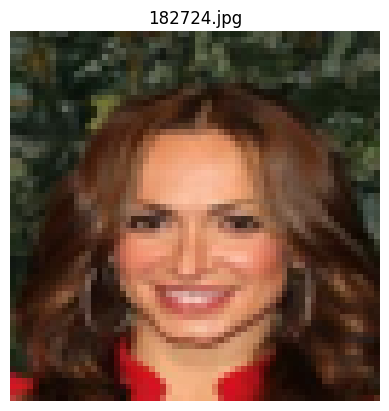

In [13]:

# selected_sample_id = ['200877.jpg'] # <-- CelebA
# selected_img = get_samples_from_loader(dataloader_test, selected_sample_id)

# random select
torch.random.manual_seed(2025)
random_picked_idx = torch.randint(0, len(dataloader_test), (1,)).item()
print(f'Randomly picked sample index: {random_picked_idx}')

# get one specific image
selected_img = b_image[random_picked_idx].unsqueeze(0)
selected_sample_id = [b_img_id[random_picked_idx]]

print(f'{selected_img.shape=}, {selected_sample_id=}')

vis_samples(selected_img, selected_sample_id)

## Get prototype activation vector and x_T

In [14]:
selected_pact = model.proactBlock(selected_img.to(device))
selected_xT = sd.reverse_sample_loop(model,selected_img.to(device), model_kwargs={'given_cond_vector':selected_pact})['sample']

## Select prototype index

In [15]:
selected_p_ind = [0,3,17,19,38]
print(f'Selected prototypes: {selected_p_ind}')

Selected prototypes: [0, 3, 17, 19, 38]


## 3 - Extrapolation

In [16]:
# get value from 0.0 to 3.0 with certain steps
p_act_values = np.linspace(0.0, 3.0, 7)
num_p_act_values_each = len(p_act_values)

enhanced_pact_chosen_p_all = []
for real_i,i_p in enumerate(selected_p_ind):
    for each_p_act in p_act_values: 
        # deep copy
        enhanced_pact_chosen_p = selected_pact.clone()
        enhanced_pact_chosen_p[:,i_p] = each_p_act
        enhanced_pact_chosen_p_all.append(enhanced_pact_chosen_p)

enhanced_pact_chosen_p_all = torch.cat(enhanced_pact_chosen_p_all,dim=0)

random_pick_img_all = selected_img.repeat(len(selected_p_ind)*num_p_act_values_each,1,1,1)
random_pick_xT_all = selected_xT.repeat(len(selected_p_ind)*num_p_act_values_each,1,1,1)

this_x_0_enhanced_all = sd.sample(model,
                                shape=random_pick_img_all.shape ,
                                noise=random_pick_xT_all,
                                progress=True,
                                model_kwargs={'given_cond_vector':enhanced_pact_chosen_p_all},
                                num_samples=1)

DEBUG:img.shape=torch.Size([35, 3, 64, 64])


  0%|          | 0/1000 [00:00<?, ?it/s]

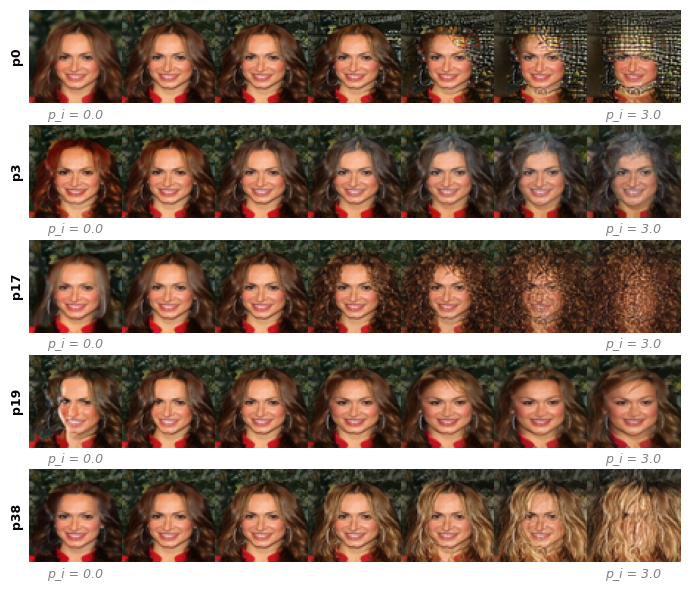

In [19]:
save_dir = REPO_HOME_DIR + 'records/extrapolation/'+f'{ds}_{version_num}'+'/'
if os.path.exists(save_dir) == False:
    os.makedirs(save_dir)


fig, ax = plt.subplots(len(selected_p_ind),num_p_act_values_each,figsize=(num_p_act_values_each*1.0,len(selected_p_ind)*1.2),dpi=100)

for real_i,i_p in enumerate(selected_p_ind):
    # plot the generated image with different p_act value
    this_x_0_enhanced = this_x_0_enhanced_all[real_i*num_p_act_values_each:(real_i+1)*num_p_act_values_each]

    
    for i in range(num_p_act_values_each):
        img = this_x_0_enhanced[i]
        ax[real_i,i].imshow(np.transpose(inverse_transform(img).type(torch.uint8).cpu().squeeze().numpy(), (1, 2, 0)))
        if i == 0:
            # ax[real_i,i].set_ylabel(f'p{selected_p_ind[real_i]}')
            ax[real_i, i].set_xticks([])  # Remove x ticks
            ax[real_i, i].set_yticks([])  # Remove y ticks
            ax[real_i, i].spines[:].set_visible(False)  # Hide all spines
            ax[real_i, i].set_ylabel(f'p{selected_p_ind[real_i]}',fontdict={'fontsize': 9, 'fontweight':'bold'})  # Ensure y-label is set
            ax[real_i, i].set_xlabel(f'p_i = 0.0',fontdict={'fontsize': 9, 'fontstyle': 'italic', 'color': 'grey'})  # Ensure y-label is set

        elif i == num_p_act_values_each-1:
            ax[real_i, i].set_xticks([])  # Remove x ticks
            ax[real_i, i].set_yticks([])  # Remove y ticks
            ax[real_i, i].spines[:].set_visible(False)  # Hide all spines
            ax[real_i, i].set_xlabel(f'p_i = 3.0', fontdict={'fontsize': 9, 'fontstyle': 'italic', 'color': 'grey'})  # Ensure y-label is set
        else:
            ax[real_i,i].axis('off')

plt.tight_layout(h_pad=0.8,w_pad=0.0)
random_pick_samples_ind_str = '-'.join(map(str, selected_p_ind))
ind_join_str = '-'.join(map(str, selected_p_ind))
# plt.savefig(save_dir + f'/extrapolation_randomsami_{random_pick_samples_ind_str}_selectedp_{ind_join_str}.pdf',bbox_inches='tight')
plt.show()